In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import sys
sys.path.append('/home/chenani/ownCloud/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import fnmatch
import itertools as it
import numpy as np
import scipy as scp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as pl
import pickle as pkl
import seaborn as sns
import os,sys
import scipy.signal as scsig
import scipy.stats as stats
import statsmodels as stm
import seaborn as sns
import colormaps as cmaps
import time
import NeuroTools as NT
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [6]:
import Recordings
import signale, trajectory, custom_plot

/home/chenani/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/chenani/anaconda2/lib/python2.7/site-packages/NeuroTools/__init__.py:125: DependencyWarning: ** interval ** package is not installed.
To have functions using interval please install the package.
website : http://pypi.python.org/pypi/interval/1.0.0

  warnings.warn(get_import_warning(name), DependencyWarning)


In [3]:
def locate(pattern, root=os.curdir):
    '''
    Locate all files matching supplied filename pattern in and below
        supplied root directory.
    Parameters
    ----------
        pattern : string
            A string representing pattern you want to look for in the path.
        root : string
            contains the path address you want to look trough!
    Returns
    ----------
        Array of strings consist of two column, first contains the path and second the file names that matched 
        the desired pattern.
    '''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield [path,filename]

def nvt_loader(filename):
    """ 
    Memory map the Neuralynx .nvt format
    Fields
    -------
    swstx
    swid
    sw_data_size
    qTimeStamps       Cheetah timestamp for this record. This value is in microseconds.
    dwpoints          Points with the color bitfield values for this record.This is a 400
                      element array.  See Video Tracker in reference. 
    sncrc
    dnextracted_x     Extracted X location of the target being tracked. 
    dnextracted_y     Extracted Y location of the target being tracked.
    dnextracted_angle The calculated head angle in degrees clockwise from the positive Y
                      axis. Zero will be assigned if angle tracking is disabled.
    dnTargets         Colored targets using the samebitfield format used by the dwPoints array.
                      Instead of transitions, the bitfield indicates the colors that make up 
                      each particular target and the center point of that target.  This is a 50
                      element array sorted by size from largest (index 0) to smallest(index 49).
                      A target value of 0 means that no target is present in thatindex location.
                      See Video Tracker Bitfield Information in reference. 
    
    Reference:
    ----------
        http://neuralynx.com/software/NeuralynxDataFileFormats.pdf
    """ 
    nev_dtype = np.dtype([
        ('swstx'              , '<i2'),
        ('swid'               , '<i2'),
        ('sw_data_size'       , '<i2'),
        ('qTimeStamps'        , '<u8'),
        ('dwPoints'           , '<u4',(400,)),
        ('sncrc'              , '<i2'),
        ('dnextracted_x'      , '<i4'),
        ('dnextracted_y'      , '<i4'),
        ('dnextracted_angle'  , '<i4'),
        ('dnTargets'          , '<i4',(50,)),
    ])
    return np.memmap(filename, dtype=nev_dtype, mode='readwrite',
       offset=(16 * 2**10))
def nev_loader(filename):
    """ Memory map the Neuralynx .nev format """ 
    nev_dtype = np.dtype([
        ('nstx'           , '<i2'),
        ('npkt_id'        , '<i2'),
        ('npkt_data_size' , '<i2'),
        ('qTimeStamps'    , '<u8'),
        ('nevent_id'      , '<i2'),
        ('nttl'           , '<i2'),
        ('ncrc'           , '<i2'),
        ('ndummy1'        , '<i2'),
        ('ndummy2'        , '<i2'),
        ('dnExtra'        , '<i4',(8,)),
        ('String'         , '<S128')
    ])
    return np.memmap(filename, dtype=nev_dtype, mode='r',
       offset=(16 * 2**10))

In [69]:
experimentFolder = '/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3906/LinearTrack_06-01-16_Day2/'
parrentFolder = experimentFolder + 'parrentData/'
vtList = sorted([os.path.join(item[0],item[1]) for item in locate('*.nvt',experimentFolder)])
vtList = [item for item in vtList if item.split('/')[-2].startswith('0') ]
vtList

['/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3906/LinearTrack_06-01-16_Day2/01-sleep1/VT1.nvt',
 '/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3906/LinearTrack_06-01-16_Day2/02-begin1/VT1.nvt',
 '/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3906/LinearTrack_06-01-16_Day2/03-sleep2/VT1.nvt']

In [70]:
traj = None
HDtraj = None
def getTraj(trajFile):
    global traj
    global HDtraj
    print 'loading', trajFile
    traj = trajectory.load_nvtFile(trajFile, 'linearMaze', showHeader=False)
    HDtraj = traj[1]        # head direction
    traj = traj[0]   

In [71]:
getTraj(vtList[1])

loading /home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3906/LinearTrack_06-01-16_Day2/02-begin1/VT1.nvt


In [72]:
###################################################### initialization
###################################################### Parameters
expType = 'real'
prefix = 'pl-'
suffix = ''
noSpeck = False
onlyRunning = True
showHeadDir = False
saveFigs = True
useRecommended = False
TTName = '.t'

# initialize in order to make them available globally
spikes=[]
ID=-1
stList=signale.spikezugList(t_start=None, t_stop=None, dims=[2])
eventData = None

cwd=os.getcwd()


###################################################### functions

def getData(folderName):
    global spikes, ID, eventData

    if os.path.isdir(folderName):
        dirList=os.listdir(folderName)
        os.chdir(folderName)
    else:
        dirList = [folderName]
    for item in sorted(dirList):
        if os.path.isfile(item):
            if (TTName.__class__ == list and item in TTName) or\
                    (TTName.__class__ == str and item.endswith(suffix+'.t') and item.startswith(prefix)):
                print 'loading', item , 'from folder: '+folderName
                spikes = signale.load_tFile(item, showHeader=False)
                ID += 1
                stList.__setitem__(ID, spikes)
                stList.addTags(ID, file=item, dir=folderName)
            
        elif os.path.isdir(item):
            getData(item)
    os.chdir('..')


In [73]:
getData(parrentFolder)

loading pl-TT12_02.t from folder: /home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3906/LinearTrack_06-01-16_Day2/parrentData/
loading pl-TT12_05.t from folder: /home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3906/LinearTrack_06-01-16_Day2/parrentData/
loading pl-TT12_09.t from folder: /home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3906/LinearTrack_06-01-16_Day2/parrentData/
loading pl-TT12_13.t from folder: /home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3906/LinearTrack_06-01-16_Day2/parrentData/
loading pl-TT12_14.t from folder: /home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3906/LinearTrack_06-01-16_Day2/parrentData/
loading pl-TT1_01.t from folder: /home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3906/LinearTrack_06-01-16_Day2/parrentData/
loading pl-TT1_03.t from folder: /home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3906/LinearTrack_06-01-16_Day2/parrentData/
loading pl-TT1_04.t from folder: /home/chenani/dataWork/ali/MECL

In [80]:
stList
stList._spikezugList__recalc_startstop()
stList.changeTimeUnit('s')

preList  =  stList.time_slice(stList.t_start,traj.t_start)
ltList   =  stList.time_slice(traj.t_start,traj.t_stop)
postList =  stList.time_slice(traj.t_stop,stList.t_stop)

In [81]:
preList[0].spike_times[:3]*1e3,postList[0].spike_times[:3]*1e3

(array([ 1534.        ,  1669.10009766,  1954.69995117], dtype=float32),
 array([ 5767923. ,  5771537.5,  5772354.5], dtype=float32))

In [86]:
preList.changeTimeUnit('s')
ltList.changeTimeUnit('s')
postList.changeTimeUnit('s')

In [87]:
A = np.array([item.mean_rate()for item in preList])
B = np.array([item.mean_rate()for item in ltList])
C = np.array([item.mean_rate()for item in postList])

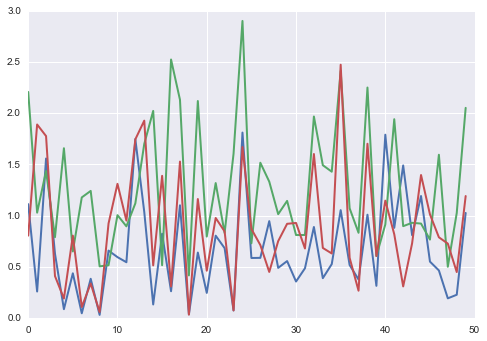

In [84]:
pl.plot(A[:])
pl.plot(B[:])
pl.plot(C[:])

1000 1000


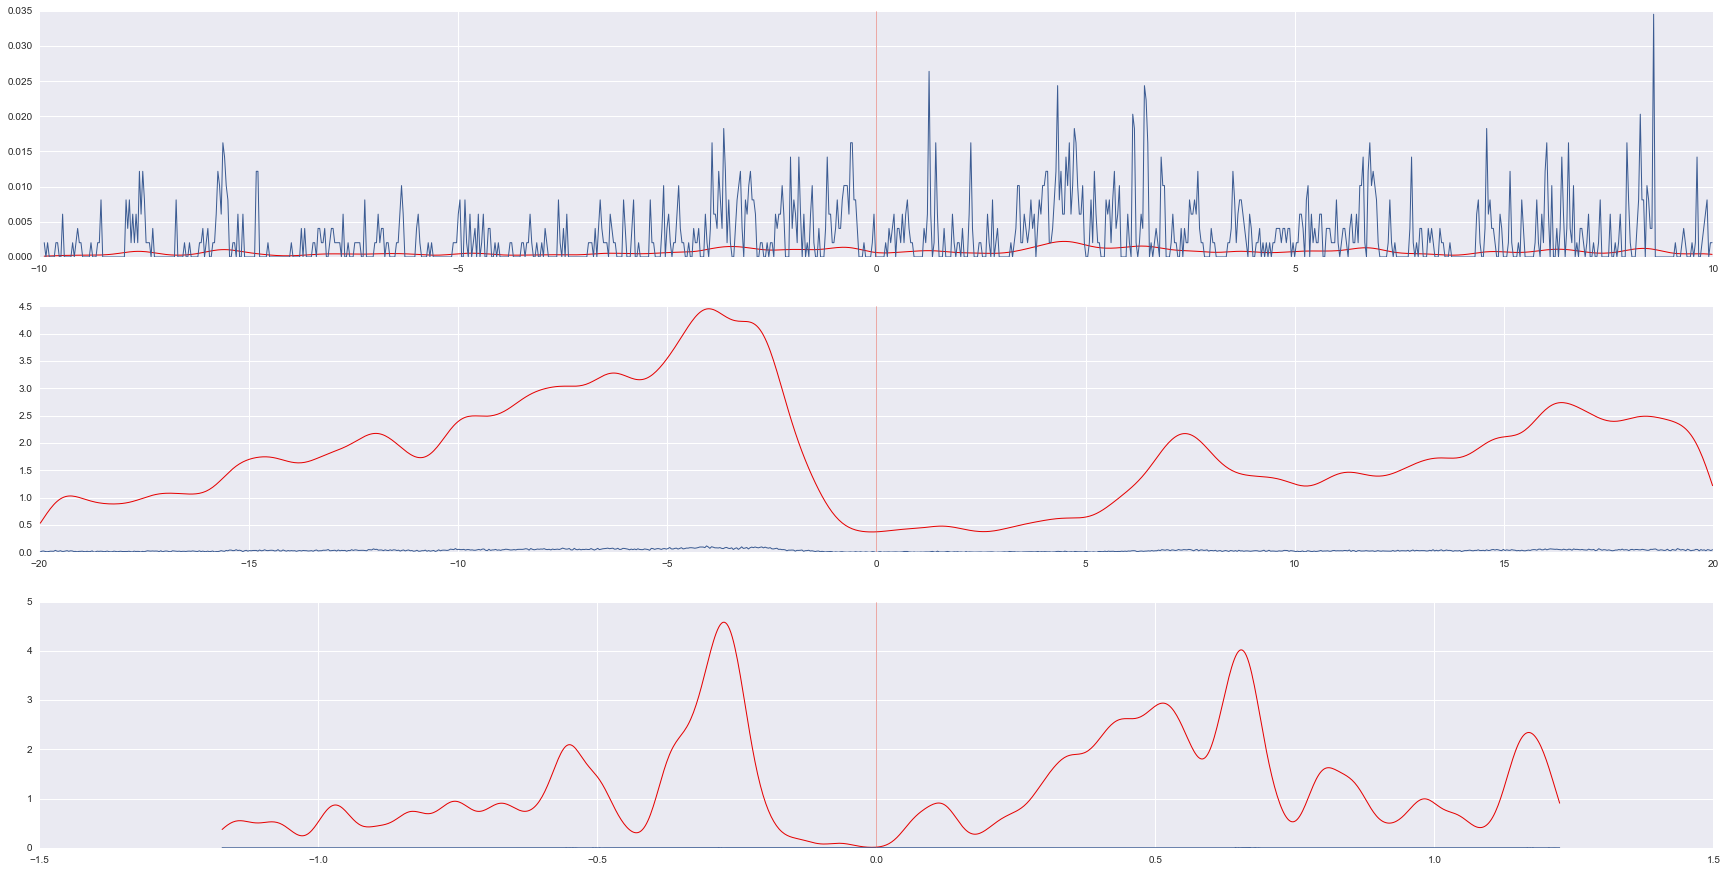

In [302]:
fig,ax = pl.subplots(3,1,figsize=[30,15])
pair = (8,29)
timeStampsA = preList[pair[0]]
timeStampsB = preList[pair[1]]
differences, pred, norm = NT.analysis.crosscorrelate(timeStampsA,timeStampsB,lag=10)
counts, bin_edges = np.histogram(differences,1e3)
kde = np.convolve(counts,scsig.gaussian(100,10),'same')
edge_distances = np.diff(bin_edges)
bin_centers = bin_edges[1:] - edge_distances/2
counts = counts / norm
xlabel = "Time"
ylabel = "Cross-correlation coefficient"
#pl.yscale('log')
print kde.size,bin_centers.size
ax[0].plot(bin_centers, kde/5e4, sns.xkcd_rgb["red"], lw=1)
ax[0].plot(bin_centers, counts, sns.xkcd_rgb["denim blue"], lw=1)
ax[0].axvline(0,linewidth=0.5,c=sns.xkcd_rgb["pale red"])
######################################
timeStampsC = ltList[pair[0]]
timeStampsD = ltList[pair[1]]
differences, pred, norm = NT.analysis.crosscorrelate(timeStampsC,timeStampsD,lag=20)
counts, bin_edges = np.histogram(differences,1000)
kde = np.convolve(counts,scsig.gaussian(100,10),'same')
kde /= kde.std()
edge_distances = np.diff(bin_edges)
bin_centers = bin_edges[1:] - edge_distances/2
counts = counts / norm
xlabel = "Time"
ylabel = "Cross-correlation coefficient"
#pl.yscale('log')
ax[1].plot(bin_centers, kde, sns.xkcd_rgb["red"], lw=1)
ax[1].plot(bin_centers, counts, sns.xkcd_rgb["denim blue"], lw=1)
ax[1].axvline(0,linewidth=0.5,c=sns.xkcd_rgb["pale red"])
####################################################
timeStampsE = postList[pair[0]]
timeStampsF = postList[pair[1]]
differences, pred, norm = NT.analysis.crosscorrelate(timeStampsE,timeStampsF,lag=1.24)
counts, bin_edges = np.histogram(differences,1000)
kde = np.convolve(counts,scsig.gaussian(100,10),'same')
kde/=kde.std()
edge_distances = np.diff(bin_edges)
bin_centers = bin_edges[1:] - edge_distances/2
counts = counts / norm
ax[2].plot(bin_centers, kde, sns.xkcd_rgb["red"], lw=1)
ax[2].plot(bin_centers, counts, sns.xkcd_rgb["denim blue"], lw=1)
ax[2].axvline(0,linewidth=0.5,c=sns.xkcd_rgb["pale red"])

In [407]:
contFactor = []
for ii in preList.id_list:
    for jj in range(ii+1,len(stList)):
        #print ii,jj
        timeStampsA = preList[ii]
        timeStampsB = preList[jj]
        differences, pred, norm = NT.analysis.crosscorrelate(timeStampsA,timeStampsB,lag=10)
        counts, bin_edges = np.histogram(differences,1e3)
        kde1 = np.convolve(counts,scsig.gaussian(100,10),'same')
        edge_distances = np.diff(bin_edges)
        bin_centers = bin_edges[1:] - edge_distances/2
        ######################################
        timeStampsC = ltList[ii]
        timeStampsD = ltList[jj]
        differences, pred, norm = NT.analysis.crosscorrelate(timeStampsC,timeStampsD,lag=20)
        counts, bin_edges = np.histogram(differences,1000)
        kde2 = np.convolve(counts,scsig.gaussian(100,10),'same')
        kde2/=kde2.std()
        edge_distances = np.diff(bin_edges)
        bin_centers = bin_edges[1:] - edge_distances/2
        ####################################################
        timeStampsE = postList[ii]
        timeStampsF = postList[jj]
        c2dist = []
        for lag in np.arange(-5,5,0.1):
            #print lag
            differences, pred, norm = NT.analysis.crosscorrelate(timeStampsE,timeStampsF,lag=np.absolute(lag))
            counts, bin_edges = np.histogram(differences,1000)
            kde3 = np.convolve(counts,scsig.gaussian(100,10),'same')
            kde3/=kde3.std()
            if lag<0:
                kde3 = kde[::-1]
            edge_distances = np.diff(bin_edges)
            bin_centers = bin_edges[1:] - edge_distances/2
            counts = counts / norm
            c2dist.append(((kde3 - kde2)**2).sum())
            #print c2dist
        #print 20.0/((np.argmin(c2dist)+1)*0.1)
        contFactor.append([20.0/((np.argmin(c2dist)+1)*0.1),np.min(c2dist)])

ValueError: max must be larger than min in range parameter.

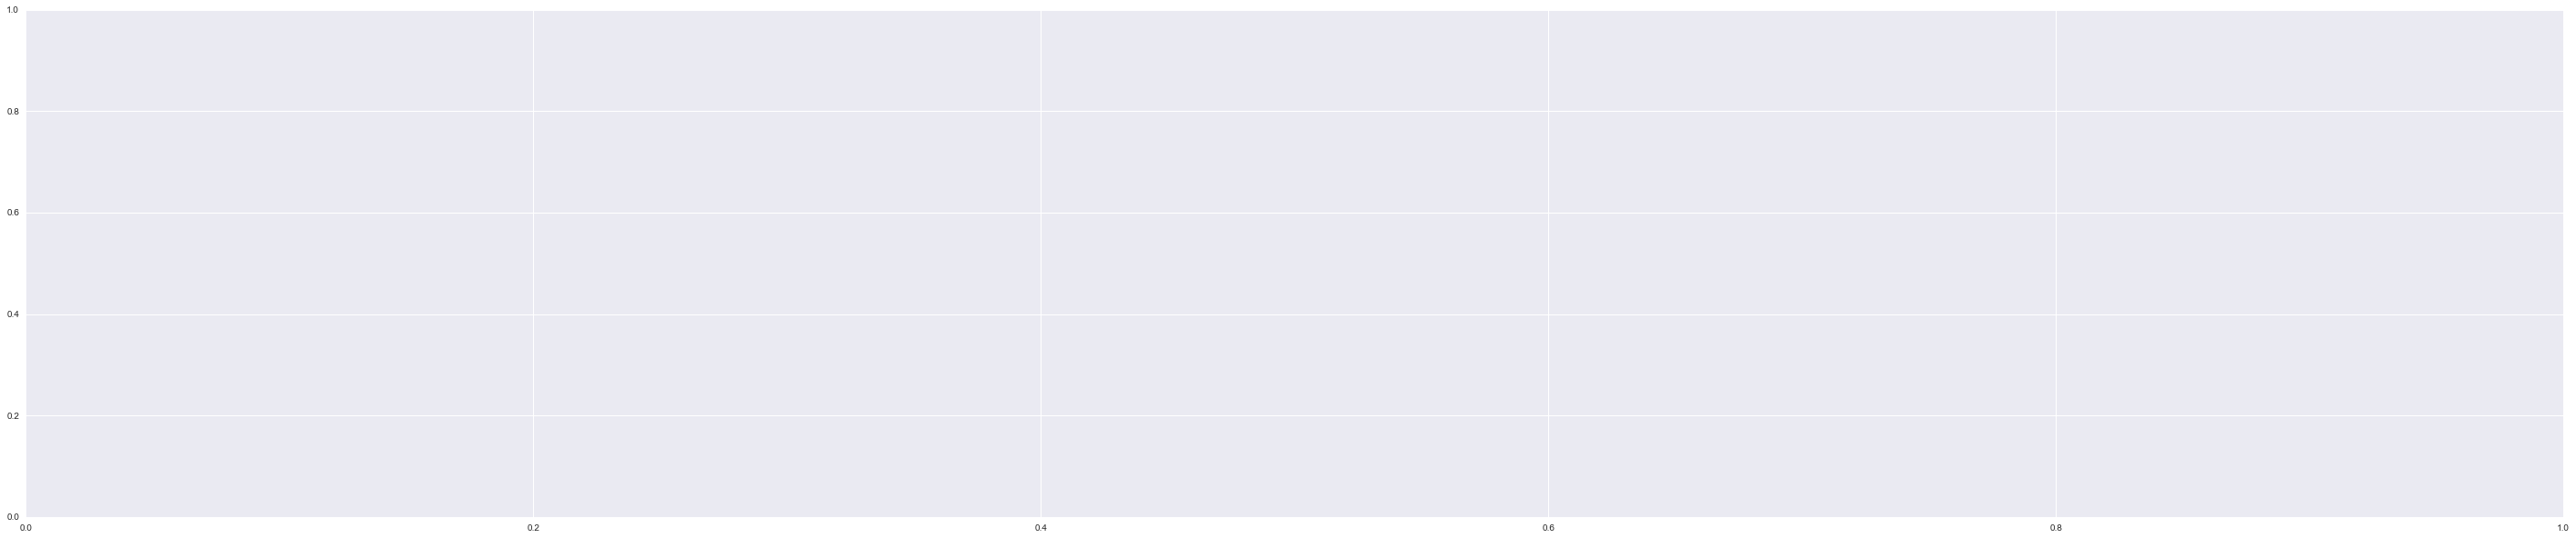

In [402]:
f,ax = pl.subplots(1,1,figsize=[50,10])
#hst,bneg = 
hst = pl.hist(contFactor,20000,log=True)[0]
#pl.xlim(0,50)

In [403]:
contFactor

[[200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, nan],
 [200.0, n

(1.0, 40000.0)

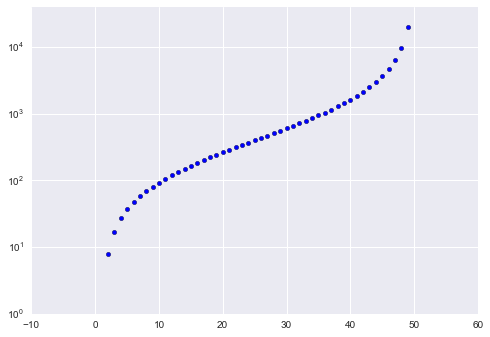

In [376]:
nZ = np.where(hst)[0]
pl.scatter(np.arange(nZ.size)+1,nZ)
#pl.plot(nZ)
#pl.plot(np.diff(nZ))
#pl.plot(np.diff(np.diff(nZ)))
#pl.plot(np.diff(np.diff(np.diff(nZ))))
#pl.xscale('log')
pl.yscale('log')
pl.ylim(1e0,4e4)

(1.0, 1000000.0)

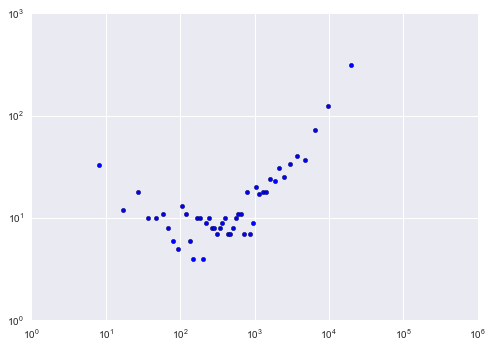

In [386]:
pl.scatter(nZ,hst[nZ])
pl.yscale('log')
pl.xscale('log')
pl.xlim(1e0,1e6)

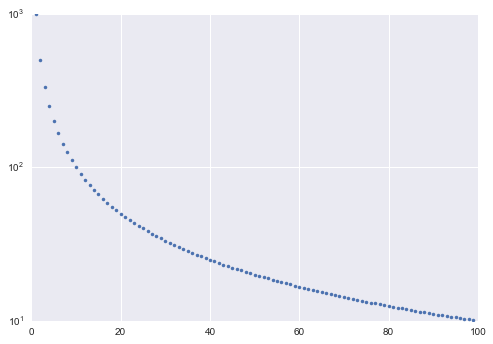

In [400]:
pl.plot(1e3*np.power(np.arange(100,dtype='float'),-1),'.')
pl.yscale('log')